<div align="center">
<p align="center" style="width: 100%;">
    <img src="https://raw.githubusercontent.com/vlm-run/.github/refs/heads/main/profile/assets/vlm-black.svg" alt="VLM Run Logo" width="80" style="margin-bottom: -5px; color: #2e3138; vertical-align: middle; padding-right: 5px;"><br>
</p>
<p align="center">
  <a href="https://docs.vlm.run"><b>Website</b></a> | 
  <a href="https://docs.vlm.run/"><b>API Docs</b></a> | 
  <a href="https://docs.vlm.run/blog"><b>Blog</b></a> | 
  <a href="https://discord.gg/AMApC2UzVY"><b>Discord</b></a> | 
  <a href="https://chat.vlm.run"><b>Chat</b></a>
</p>
</div>

# VLM Run Orion - Plot Generation from Statistical Data

This comprehensive cookbook demonstrates [VLM Run Orion's](https://vlm.run/orion) capabilities in generating insightful visualizations from statistical datasets using natural language prompts. Leverage the power of multimodal AI to transform raw numbers into clear, publication-ready charts—without writing plotting code.

For this notebook, we'll cover how to use the **VLM Run Agent Chat Completions API**—an OpenAI-compatible interface that supports image and data inputs alongside text—to generate plots directly from structured data.

We'll cover the following topics:
1. **Data Ingestion** – Upload CSV, JSON, or Excel files and reference them in prompts
2. **Natural Language to Plot** – Describe the desired visualization (e.g., “bar chart of sales by region”) and let Orion generate it
3. **Custom Styling & Types** – Request specific chart types (scatter, histogram, time series, etc.) and styling preferences
4. **Multi-Plot Analysis** – Generate comparative or dashboard-style visualizations across multiple datasets

## Prerequisites

- Python 3.10+
- VLM Run API key (get one at [app.vlm.run](https://app.vlm.run))
- VLM Run Python Client with OpenAI extra: `pip install "vlmrun[openai]"`

## Setup

First, install the required packages and configure the environment.

In [1]:
# Install required packages
!pip install vlmrun[openai] --upgrade --quiet
!pip install pillow requests numpy --quiet


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os
import getpass
import json
from typing import List, Any
from functools import cached_property

import numpy as np
from PIL import Image
from pydantic import BaseModel, Field

VLMRUN_API_KEY = os.getenv("VLMRUN_API_KEY", None)
if VLMRUN_API_KEY is None:
    VLMRUN_API_KEY = getpass.getpass("Enter your VLM Run API key: ")

## Initialize the VLM Run Client

We use the OpenAI-compatible chat completions interface through the VLM Run SDK.

In [3]:
from vlmrun.client import VLMRun

client = VLMRun(
    api_key=VLMRUN_API_KEY, base_url="https://agent.vlm.run/v1"
)
print("VLM Run client initialized successfully!")
print(f"Base URL: https://agent.vlm.run/v1")
print(f"Model: vlmrun-orion-1")

VLM Run client initialized successfully!
Base URL: https://agent.vlm.run/v1
Model: vlmrun-orion-1


## Response Models (dtypes)

We define structured Pydantic models to capture proofreading feedback with full traceability.

In [4]:
from typing import List, Optional, Dict, Any
from pydantic import BaseModel, Field

class ImageRef(BaseModel):
    id: str = Field(..., description="Artifact ID of the image")

class TrimmedImage(BaseModel):
    """A cropped image extracted from a PDF page."""
    image: ImageRef
    caption: Optional[str] = Field(None, description="Optional caption or description of the image")
    xywh_norm: tuple[float, float, float, float] = Field(..., description="Normalized bounding box (x, y, w, h) on the page")

class HighlightedText(BaseModel):
    """Text segment that was highlighted or emphasized in the PDF."""
    text: str = Field(..., description="The highlighted text content")
    page_number: int = Field(..., description="Page number where the highlight appears")
    context: Optional[str] = Field(None, description="Surrounding paragraph for context")

class KeyPoint(BaseModel):
    """A concise, important insight extracted from the document."""
    statement: str = Field(..., description="The key point or finding")
    page_numbers: List[int] = Field(..., description="Pages where supporting evidence appears")

class SummaryResponse(BaseModel):
    """High-level summary of the entire PDF document."""
    summary: str = Field(..., description="Concise overview of the document's purpose and conclusions")
    key_points: List[KeyPoint] = Field(..., description="List of critical takeaways")
    highlighted_texts: List[HighlightedText] = Field(..., description="All highlighted or annotated text segments")

class GeneratedPlot(BaseModel):
    """A plot generated from structured data (e.g., tables) in the PDF."""
    image: ImageRef
    explanation: str = Field(..., description="Natural language explanation of what the plot shows and why it matters")
    source_table_page: int = Field(..., description="Page number of the source table or data")
    plot_type: str = Field(..., description="Type of plot (e.g., bar chart, line graph, scatter plot)")

class PDFAnalysisResponse(BaseModel):
    """Comprehensive analysis of a PDF document."""
    document_summary: SummaryResponse
    trimmed_images: List[TrimmedImage] = Field(..., description="Relevant figures or diagrams, cropped and referenced by page")
    generated_plots: List[GeneratedPlot] = Field(..., description="Visualizations created from tabular or statistical data in the PDF")

    def __repr__(self):
        return (
            f"PDFAnalysisResponse("
            f"pages_with_images={sorted(set(img.image.page_number for img in self.trimmed_images))}, "
            f"plots={len(self.generated_plots)}, "
            f"key_points={len(self.document_summary.key_points)})"
        )

print("PDF analysis response models defined successfully!")

PDF analysis response models defined successfully!


## Helper Functions

We create helper functions to simplify making chat completion requests with structured outputs.

In [5]:
import hashlib
import cachetools
from typing import Type, TypeVar
from IPython.display import HTML
from vlmrun.common.image import encode_image


T = TypeVar('T', bound=BaseModel)


def display(images: Image.Image | list[Image.Image], texts: list[str] | None = None, width: int = 300):
    if isinstance(images, Image.Image):
        images = [images]
    if texts == None:
        texts = [None] * len(images)
    elif isinstance(texts, str):
        texts = [texts]
    elif len(texts) != len(images):
        raise ValueError("`texts` must be a list of the same length as `images`")

    imgs_html = ""
    for image, text in zip(images, texts):
        W, H = image.size
        if W > width:
            H = int(H * width / W)
            W = width
            image = image.resize((W, H))
        im_bytes = encode_image(image, format="JPEG")
        imgs_html += f"<div style='display:inline-block; margin:5px; text-align:center'>"
        imgs_html += f"<img src='{im_bytes}' style='width:{width}px; border-radius:6px'>"
        if text:
            imgs_html += f"<div style='font-size:12px; color:#666; margin-top:5px'>{text}</div>"
        imgs_html += f"</div>"
    return HTML(f"<div style='display:flex; flex-wrap:wrap'>{imgs_html}</div>")


def custom_key(prompt: str, images: list[Image.Image] | list[str] | None = None, doc: list[str] | None = None, response_model: Type[T] | None = None, model: str = "vlmrun-orion-1:auto"):
    """Custom key for caching chat_completion."""
    image_keys = []
    if images:
        for image in images:
            if isinstance(image, Image.Image):
                thumb = image.copy()
                thumb.thumbnail((128, 128))
                encoded = encode_image(thumb, format="JPEG")
                image_keys.append(encoded)
            elif isinstance(image, str):
                image_keys.append(image)

    doc_keys = []
    if doc:
        if isinstance(doc, str):
            doc_keys.append(doc)
        elif isinstance(doc, list):
            for d_url in doc:
                doc_keys.append(d_url)

    response_key = hashlib.sha256(json.dumps(response_model.model_json_schema(), sort_keys=True).encode()).hexdigest() if response_model else ""
    return (prompt, tuple(image_keys), tuple(doc_keys), response_key, model)


@cachetools.cached(cache=cachetools.TTLCache(maxsize=1000, ttl=3600), key=custom_key)
def chat_completion(
    prompt: str,
    images: list[Image.Image] | list[str] | None = None,
    doc: list[str] | None = None,
    response_model: Type[T] | None = None,
    model: str = "vlmrun-orion-1:auto"
) -> Any:
    """
    Make a chat completion request with optional images and structured output.

    Args:
        prompt: The text prompt/instruction
        images: Optional list of images to process (either PIL Images or URLs)
        response_model: Optional Pydantic model for structured output
        model: Model to use (default: vlmrun-orion-1:auto)

    Returns:
        Parsed response model if response_model provided, else raw response text
    """
    content = []
    content.append({"type": "text", "text": prompt})
    if doc:
        if isinstance(doc, str):
            content.append({
                    "type": "file_url",
                    "file_url": {"url": doc, "detail": "auto"}
                })
        elif isinstance(doc, list):
            for d_url in doc:
                assert isinstance(d_url, str) and d_url.startswith("http"), "Document URLs must be strings starting with http or https"
                content.append({
                    "type": "file_url",
                    "file_url": {"url": d_url, "detail": "auto"}
                })


    if images:
        for image in images:
            if isinstance(image, str):
                assert image.startswith("http"), "Image URLs must start with http or https"
                content.append({
                    "type": "image_url",
                    "image_url": {"url": image, "detail": "auto"}
                })
            elif isinstance(image, Image.Image):
                content.append({
                    "type": "image_url",
                    "image_url": {"url": encode_image(image, format="JPEG"), "detail": "auto"}
                })
            else:
                raise ValueError("Images must be either PIL Images or URLs")

    kwargs = {
        "model": model,
        "messages": [{"role": "user", "content": content}]
    }

    if response_model:
        kwargs["response_format"] = {
            "type": "json_schema",
            "schema": response_model.model_json_schema()
        }

    response = client.agent.completions.create(**kwargs)
    response_text = response.choices[0].message.content

    if response_model:
        return response_model.model_validate_json(response_text), response.session_id

    return response_text, response.session_id

print("Helper functions defined!")

Helper functions defined!


### Plot Generation Capabilities

VLM Run Orion can interpret structured data files and generate insightful visualizations based on natural language instructions. Below, we demonstrate core workflows.

### 1. Data Ingestion & Basic Plot

Upload a pdf file and ask Orion to generate a simple plot.

In [10]:
DATA_URL = "https://www.eia.gov/outlooks/ieo/data/pdf/A_A18_r_230822.081459.pdf"

result, session_id = chat_completion(
prompt="Generate a bar chart showing total income by region. Use a clean, professional style suitable for a business report.",
doc=[DATA_URL],
response_model=GeneratedPlot
)

print(">> GENERATED PLOT")
print(f"Type: {result.plot_type}")
print(f"Explanation: {result.explanation}")

>> GENERATED PLOT
Type: bar chart
Explanation: The bar chart illustrates the significant disparities in disposable income per capita across different global regions for the year 2022. The Americas and Europe/Eurasia lead with over $20,000 per capita, while the Asia Pacific and Africa/Middle East regions show considerably lower levels, highlighting global economic inequality. Data was sourced from page 1 of the provided document.



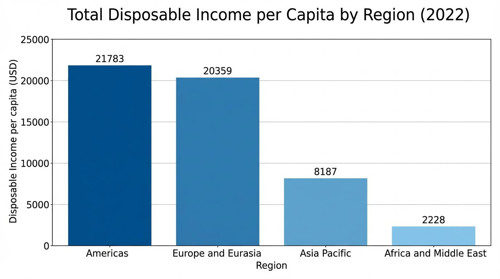

In [11]:
plot_img: Image.Image = client.artifacts.get(session_id=session_id, object_id=result.image.id)

display(plot_img, texts=["Income by Region"], width=500)

### 2. Natural Language to Plot with Custom Styling


Request specific aesthetics or chart types using descriptive language.

In [13]:
DATA_URL = "https://www.weather.gov/media/slc/ClimateBook/Annual%20Average%20Temperature%20By%20Year.pdf"

result, session_id = chat_completion(
prompt="Create a line graph of average monthly temperatures over the year. Use a blue gradient, smooth interpolation, and highlight hottest year in orange.",
doc=[DATA_URL],
response_model=GeneratedPlot
)

print(">> STYLED PLOT")
print(f"Type: {result.plot_type}")
print(f"Explanation: {result.explanation}")

>> STYLED PLOT
Type: line graph
Explanation: This line graph illustrates the trend in average annual temperatures from 1875 to 2023, based on the data in the provided document. The document contains annual averages rather than monthly data. The graph uses a blue gradient and smooth interpolation to show the overall warming trend over the decades. The year 2012, identified as the hottest year in the record with an average temperature of 56.6°F, is highlighted in orange to stand out.



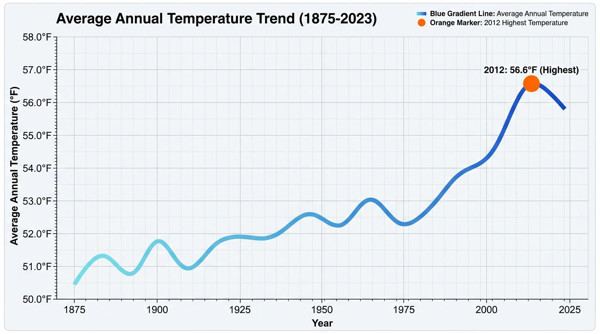

In [14]:
plot_img: Image.Image = client.artifacts.get(session_id=session_id, object_id=result.image.id)

display(plot_img, texts=["Temperature Trends"], width=600)

### 3. Multi-Series Comparison

Generate comparative visualizations from datasets with multiple variables.

In [16]:
DATA_URL = "https://fiscaldata.treasury.gov/static-data/published-reports/exchange-rates/Rates_of_Exchange_12312024.pdf"

result, session_id = chat_completion(
prompt="Plot exchange rate versus dollar from the Treasury Reporting Rates of Exchange as a scatter plot. Label each point with the coutry name and use distinct colors.",
doc=[DATA_URL],
response_model=GeneratedPlot
)

print(">> MULTI-SERIES SCATTER PLOT")
print(f"Type: {result.plot_type}")
print(f"Explanation: {result.explanation}")

>> MULTI-SERIES SCATTER PLOT
Type: scatter plot
Explanation: The scatter plot displays the Treasury Reporting Rates of Exchange for selected countries relative to the US Dollar as of December 31, 2024. Each point is labeled with its corresponding country name and assigned a unique color, illustrating the variance in exchange rates (units of foreign currency per 1 USD). For instance, the Euro and British Pound are stronger than the dollar (rates < 1), while the Japanese Yen and Indian Rupee show significantly higher values per dollar.



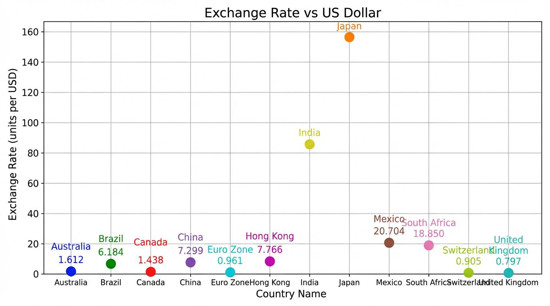

In [17]:
plot_img: Image.Image = client.artifacts.get(session_id=session_id, object_id=result.image.id)

display(plot_img, texts=["Exchange Rate by Country"], width=550)

### 4. Dashboard-Style Multi-Plot Analysis

Ask for multiple related plots in one request (e.g., for executive dashboards).

In [21]:
class MultiPlotResponse(BaseModel):
    plots: List[GeneratedPlot] = Field(..., description="List of complementary visualizations")
    dashboard_title: str = Field(..., description="Overall title summarizing the dashboard theme")

DATA_URLS = [
    "https://www.census.gov/retail/marts/www/marts_current.pdf",
    "https://www.ahima.org/media/betc41er/salary-snapshot.pdf"
]

In [22]:
result, session_id = chat_completion(
prompt=(
    "Analyze these two files: contains salary for different occupations"
    "Generate a dashboard with two plots: (1) a time series of salary, and (2) a pie chart of occupation groups. "
    "Ensure consistent color palette and professional layout."
),
doc=DATA_URLS,
response_model=MultiPlotResponse
)

print(">> DASHBOARD RESPONSE")
print(f"Title: {result.dashboard_title}")
print(f"Number of plots: {len(result.plots)}")

>> DASHBOARD RESPONSE
Title: US Salary Analysis for Health Information Management (HIM) Professionals
Number of plots: 2



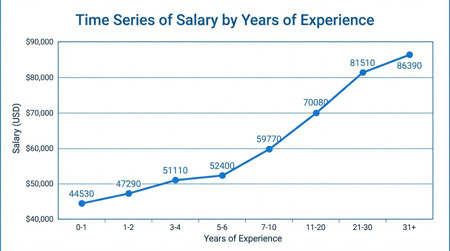
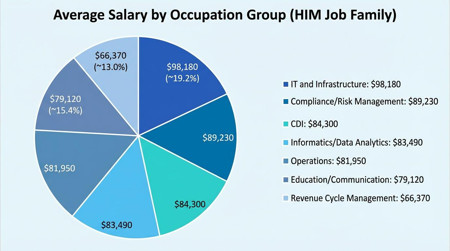

In [23]:
images = []
captions = []

for i, plot in enumerate(result.plots):
    img = client.artifacts.get(session_id=session_id, object_id=plot.image.id)
    images.append(img)
    captions.append(f"{i+1}. {plot.plot_type.title()} - {plot.explanation[:60]}...")

display(images, texts=captions, width=450)

## Conclusion

This cookbook demonstrated how VLM Run Orion transforms statistical data into insightful, publication-ready visualizations using only natural language.


### Key Takeaways

1. **Data Ingestion**: Supports CSV, tables inside PDFs via file URLs.

2. **Natural Language Interface**: Describe plots conversationally.

3. **Styling Control**: Specify colors, labels, highlights, and aesthetics in plain English.

4. **Multi-Plot Workflows**: Generate dashboards or comparative analyses in a single call.

5. **Structured Outputs**: Use Pydantic models with `response_model` parameter to get type-safe, validated responses with automatic parsing.


### Use Cases

- Automated report generation for finance, marketing, or operations
- Rapid data exploration during analysis
- Accessibility tool for non-technical stakeholders
- Visual ETL: turn raw data → insight → image in one step

### Next Steps

- Explore the [VLM Run Documentation](https://docs.vlm.run) for more details
- Join our [Discord community](https://discord.gg/AMApC2UzVY) for support
- Check out more examples in the [VLM Run Cookbook](https://github.com/vlm-run/vlmrun-cookbook)
- Review domain-specific redaction agents for financial, healthcare, legal, and other industries

Happy building!